### Import Modules

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import time
import pickle

import warnings
warnings.filterwarnings('ignore')
%matplotlib nbagg

### Import Data

In [7]:
# constants
lr = 230        # length of road [m]
dt = 0.025      # update time [s]
t_final = 2000  # simulation time [s]
ind_cars_const = np.array([])  # indices of cars that do not change lanes

t = np.arange(0, t_final+dt, dt)

In [8]:
# import pickle data
results = pickle.load(open('data.pkl', 'rb'))

In [9]:
# choose simulation
simulation = results[0]

# separate output values
pos_absolute = simulation['position']
vel = simulation['velocity']
headway = simulation['headway']
n_cars_cur = simulation['num_cars']
num_enters = simulation['num_enters']
num_exits = simulation['num_exits']
pos_rad = np.divide(pos_absolute, lr) * (2*np.pi)

### Video

<IPython.core.display.Javascript object>


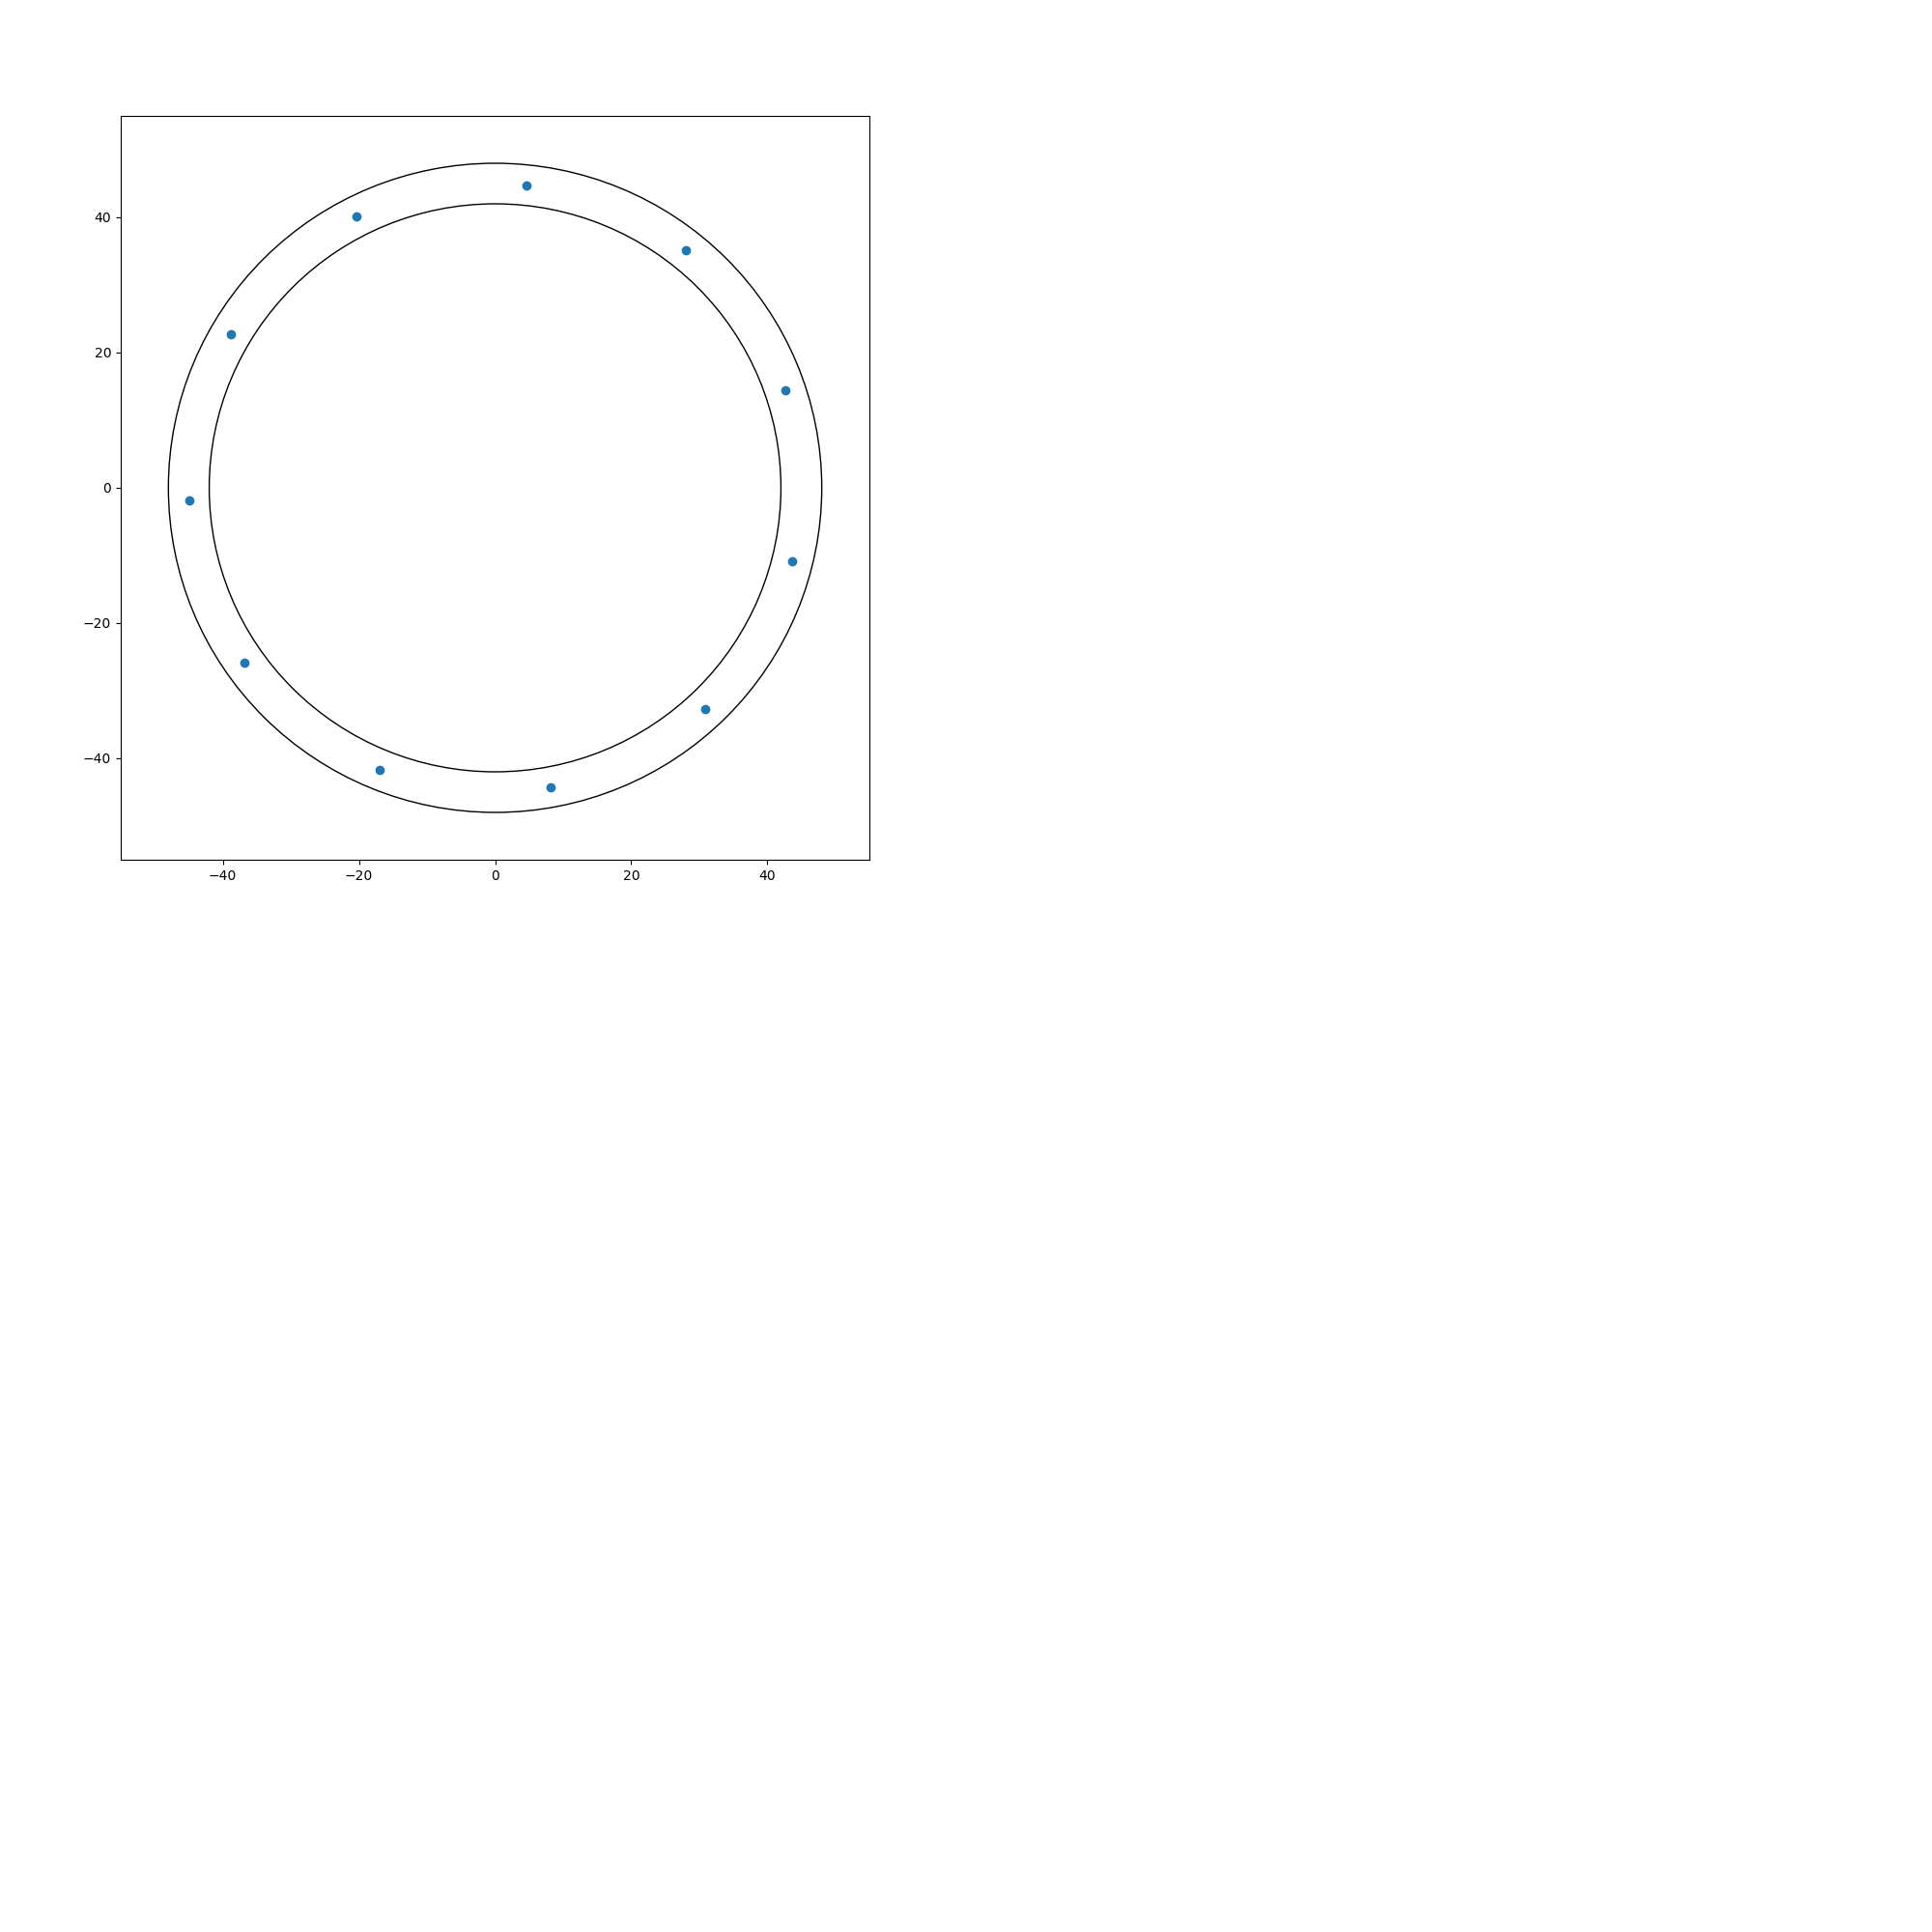

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# initial x and y data
x = 45 * np.cos(pos_rad)
y = 45 * np.sin(pos_rad)

li1, = ax.plot(x[0,4:], y[0,4:], 'o')
li2, = ax.plot(x[0,:4], y[0,:4], 'o', c='r')

# draw circular road
circle1 = plt.Circle((0, 0), 42, color='k', fill=False)
circle2 = plt.Circle((0, 0), 48, color='k', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

# draw and show it
fig.canvas.draw()
plt.xlim([-55,55])
plt.ylim([-55,55])
plt.show(block=False)

# loop to update the data
for i in range(1,len(t),10):
    # set the new data
    li1.set_xdata(x[i,pos_rad[i,:]!=0])
    li1.set_ydata(y[i,pos_rad[i,:]!=0])
    li2.set_xdata(x[i,pos_rad[i,:len(ind_cars_const)]!=0])
    li2.set_ydata(y[i,pos_rad[i,:len(ind_cars_const)]!=0])
    
    fig.canvas.draw()
    # time.sleep(0.1)

### Time-space diagram

<IPython.core.display.Javascript object>


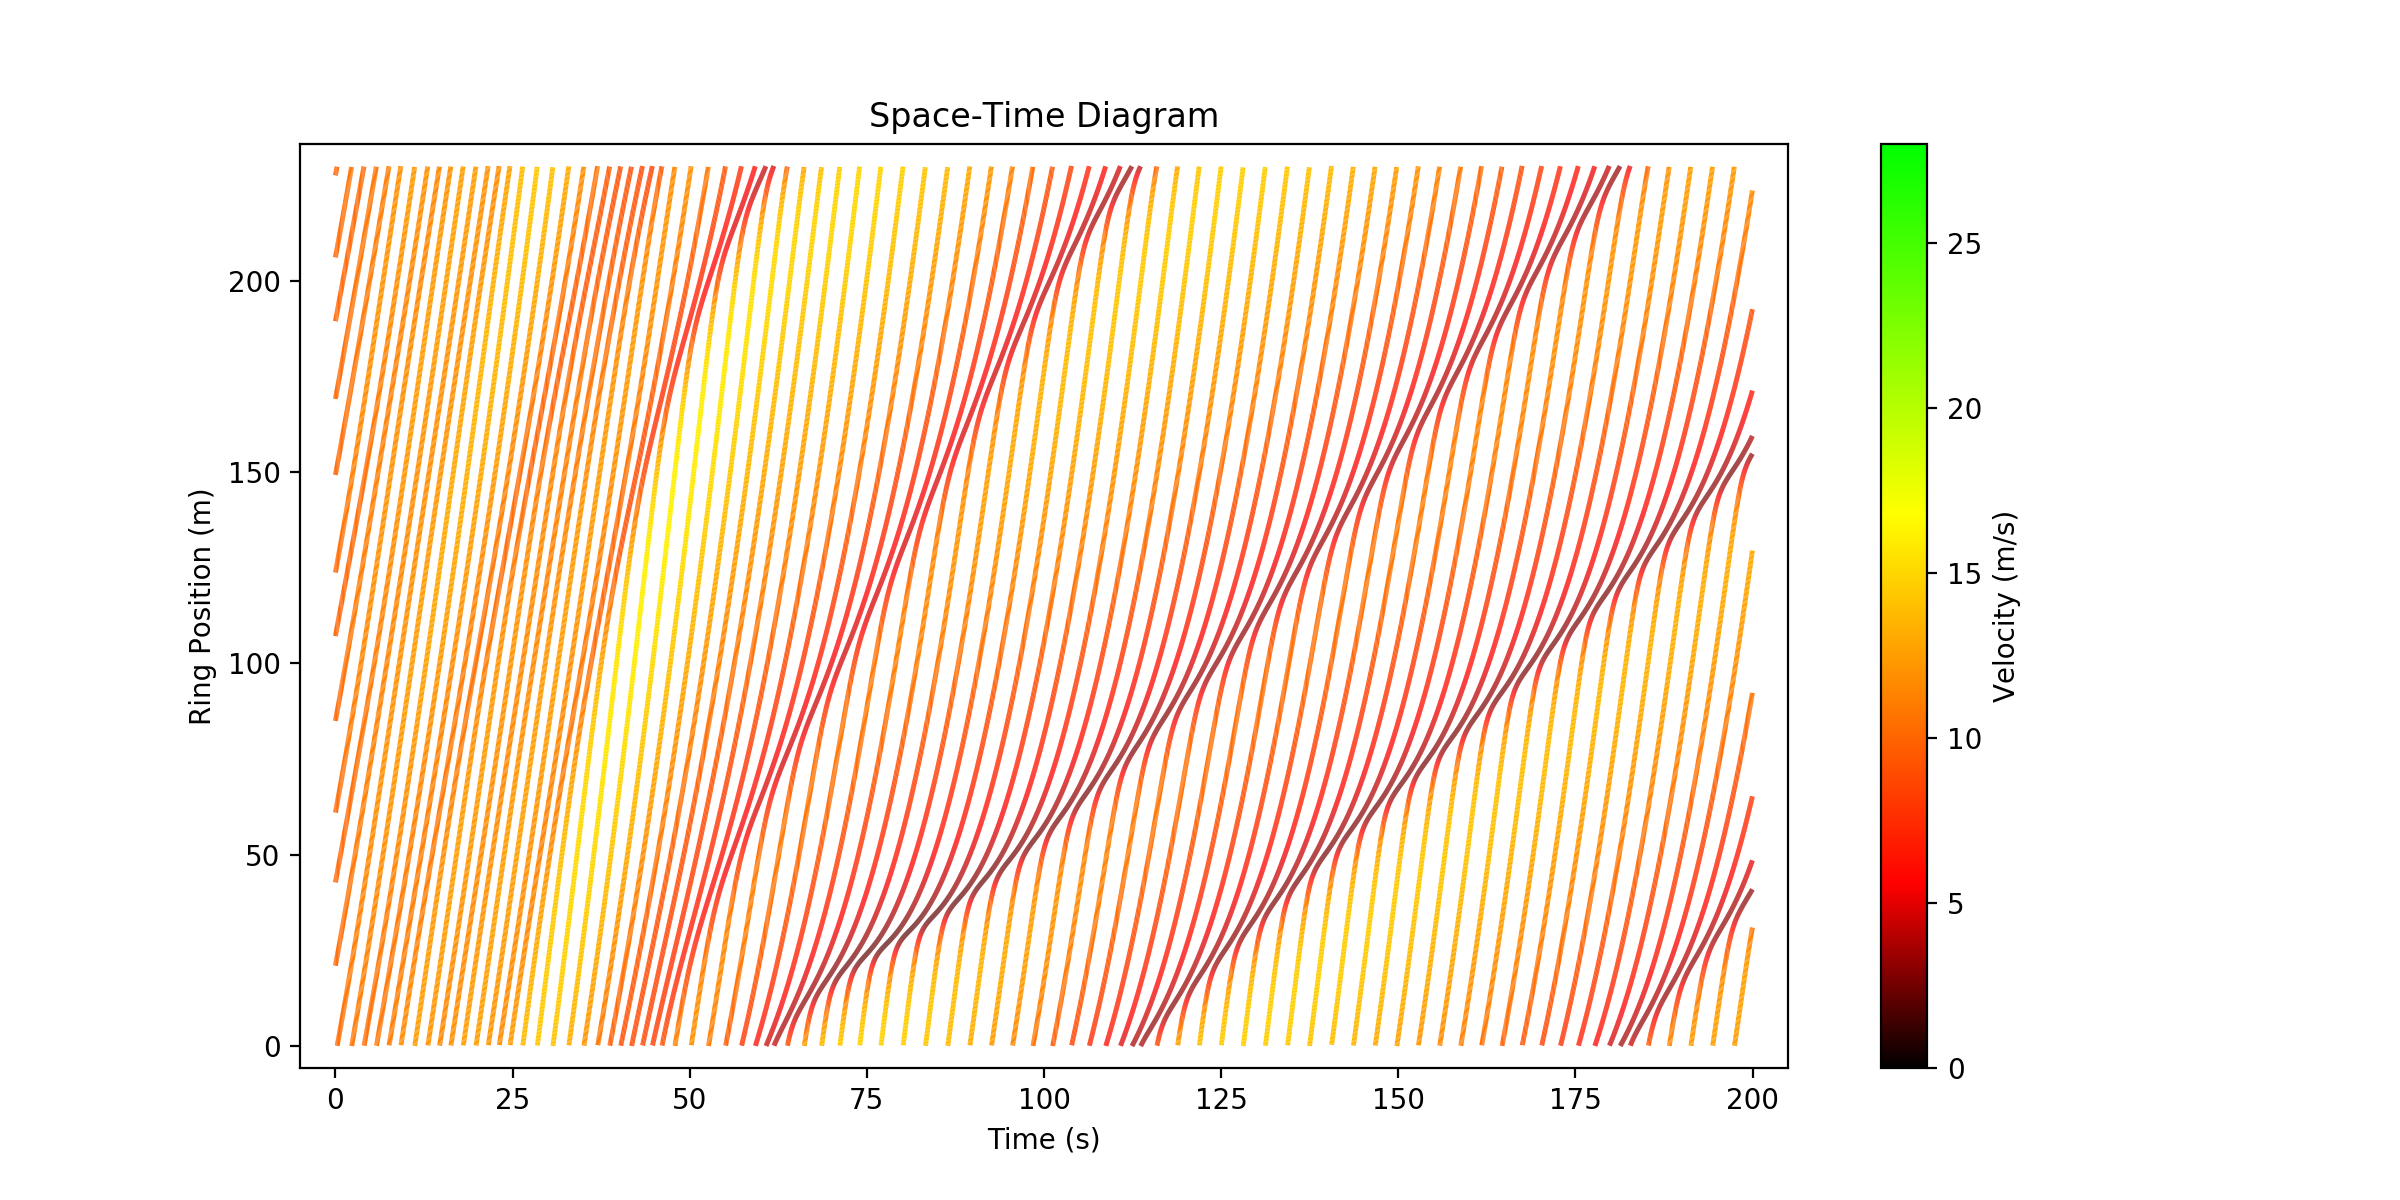

In [10]:
# Plot all cars at once, but for a snippet of the overall simulation run
step_min = 0*2000
step_max = 4*2000

# color scheme
cdict = {'red'  :  ((0., 0., 0.), (0.2, 1., 1.), (0.6, 1., 1.), (1., 0., 0.)),
        'green':  ((0., 0., 0.), (0.2, 0., 0.), (0.6, 1., 1.), (1., 1., 1.)),
        'blue' :  ((0., 0., 0.), (0.2, 0., 0.), (0.6, 0., 0.), (1., 0., 0.))}
my_cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

    
fig = plt.figure(figsize=(12, 6))
ax = plt.axes()

norm = plt.Normalize(0, 28) # TODO: Make this more modular
cols = []
    
# i is each vehicle that ever exists in the simulation
for i in range(int(pos_absolute.shape[1])):
    valid_ind = pos_absolute[step_min:step_max,i]!=0

    unique_car_time = t[step_min:step_max][valid_ind]
    unique_car_pos = pos_absolute[step_min:step_max][valid_ind][:,i]%lr

    # discontinuity from wraparound
    disc = np.where(np.abs(np.diff(unique_car_pos)) >= 0.5)[0]+1
    unique_car_time = np.insert(unique_car_time, disc, np.nan)
    unique_car_pos = np.insert(unique_car_pos, disc, np.nan)
    unique_car_speed = np.insert(vel[step_min:step_max][valid_ind][:,i], disc, np.nan)

    points = np.array([unique_car_time, unique_car_pos]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=my_cmap, norm=norm)

    # Set the values used for colormapping
    lc.set_array(unique_car_speed)
    lc.set_linewidth(1.75)
    cols = np.append(cols, lc)
    
for col in cols: line = ax.add_collection(col)
cbar = fig.colorbar(line, ax = ax)
cbar.set_label('Velocity (m/s)', fontsize = 10)
plt.title('Space-Time Diagram', fontsize=12)
plt.ylabel('Ring Position (m)', fontsize=10)
plt.xlabel('Time (s)', fontsize=10)

xmin, xmax = t[step_min], t[step_max]
xbuffer = (xmax - xmin) * 0.025
ymin, ymax = 0, lr
ybuffer = (ymax - ymin) * 0.025

ax.set_xlim(xmin - xbuffer, xmax + xbuffer)
ax.set_ylim(ymin - ybuffer, ymax + ybuffer)

plt.show()

### Headway Profile (Convergence plot)

In [22]:
print("Average number of cars (nbar):", np.average(n_cars_cur))
# TODO compute the equilibrium headway and velocity at nbar
print("h_nbar^*:")
print("v_nbar^*:")

Average number of cars (nbar): 17.8879639005
h_nbar^*:
v_nbar^*:


<IPython.core.display.Javascript object>


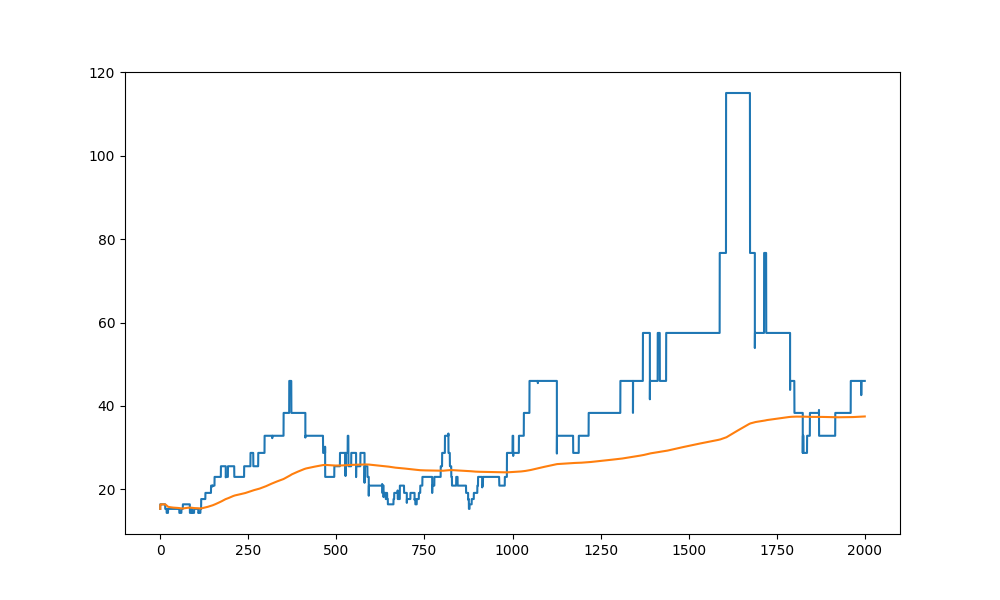

<IPython.core.display.Javascript object>


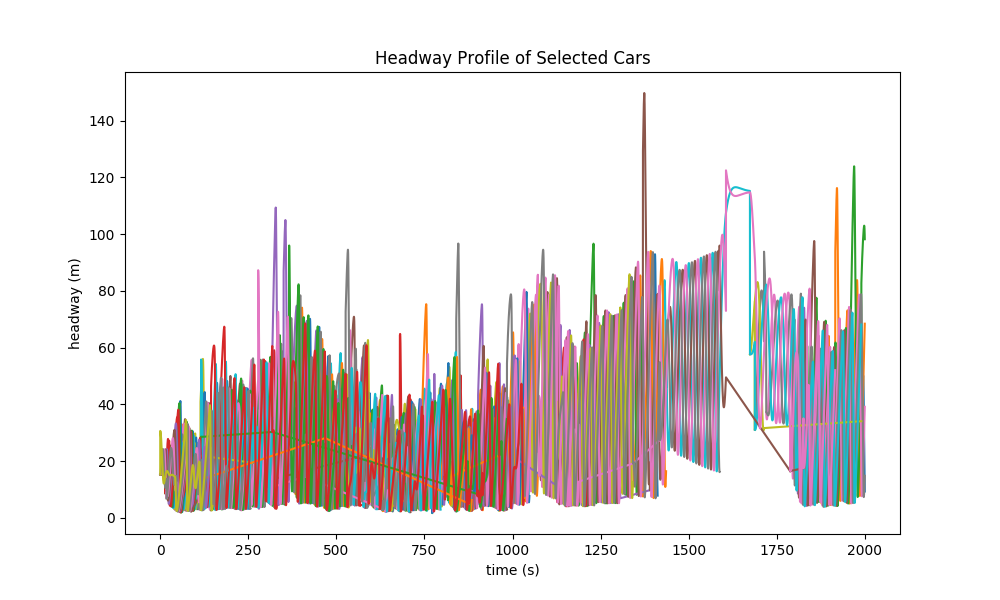

1.7417224523592267

In [26]:
# calculate average headway
avg_headway = np.zeros(headway.shape[0])
convg_headway = np.zeros(headway.shape[0])

for i in range(avg_headway.shape[0]):
    avg_headway[i] = np.sum(headway[i,:])/sum(headway[i,:]!=0)
    convg_headway[i] = np.average(avg_headway[0:i])
    
plt.figure(figsize=(10,6))

plt.plot(t[avg_headway!=0], avg_headway[avg_headway!=0])
plt.plot(t[convg_headway!=0], convg_headway[convg_headway!=0])

plt.figure(figsize=(10,6))

for i in range(headway.shape[1]):
    plt.plot(t[headway[:,i]!=0], headway[headway[:,i]!=0][:,i])

plt.title("Headway Profile of Selected Cars")
plt.xlabel('time (s)')
plt.ylabel('headway (m)')
plt.show()

np.max(headway)
np.min(headway[headway>0])

<IPython.core.display.Javascript object>


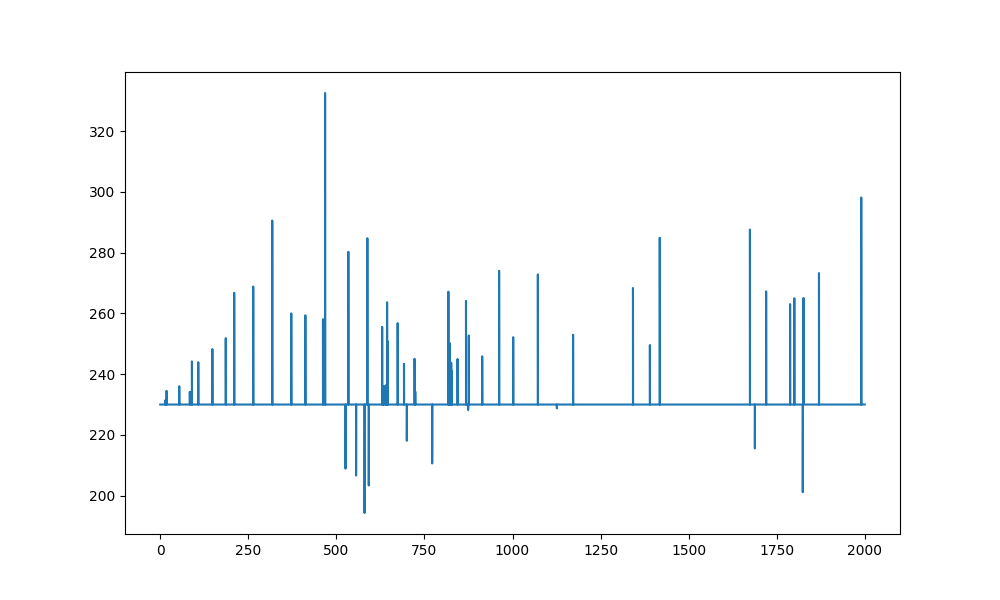

In [27]:
sum_headway = []

for i in range(headway.shape[0]):
    sum_headway.append(sum(headway[i,:]))

plt.figure(figsize=(10,6))
plt.plot(t, sum_headway)
plt.show()

### Velocity Profile

14.7436942009


<IPython.core.display.Javascript object>


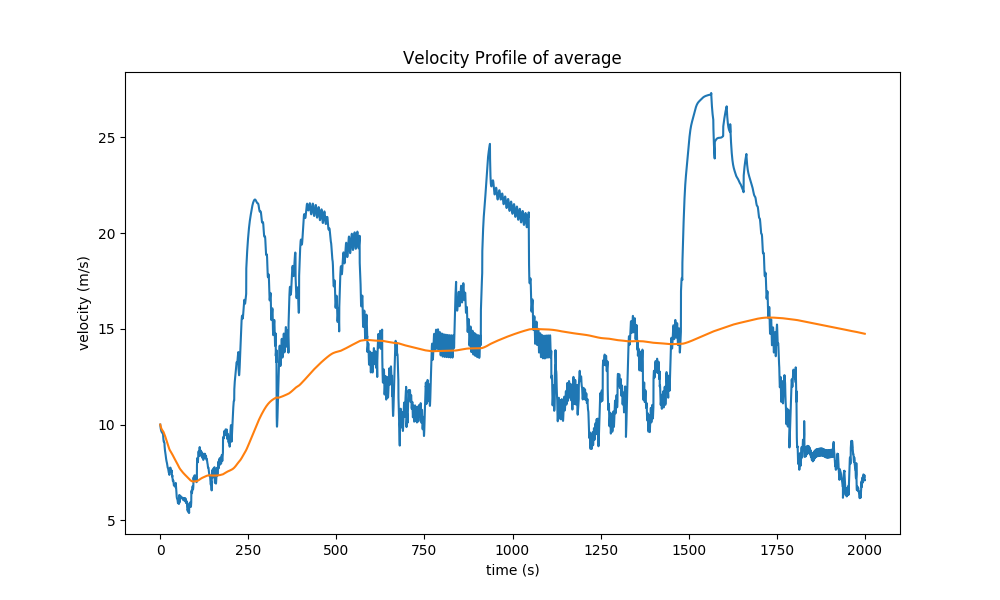

<IPython.core.display.Javascript object>


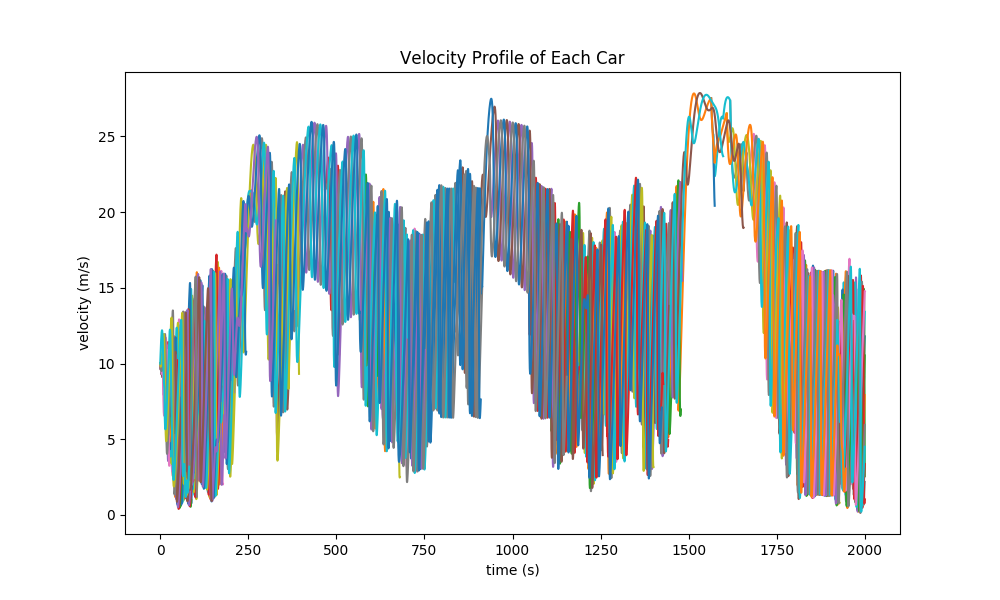

In [31]:
avg_vel = np.zeros(vel.shape[0])
convg_vel = np.zeros(vel.shape[0])
for i in range(avg_vel.shape[0]):
    avg_vel[i] = np.sum(vel[i,:])/sum(vel[i,:]!=0)
    convg_vel[i] = np.average(avg_vel[0:i])

print(convg_vel[-1])
plt.figure(figsize=(10,6))
plt.plot(t[avg_vel!=0], avg_vel[avg_vel!=0])
plt.plot(t[convg_vel!=0], convg_vel[convg_vel!=0])

plt.title("Velocity Profile of average")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()    
    
plt.figure(figsize=(10,6))

for i in range(vel.shape[1]):
    plt.plot(t[vel[:,i]!=0], vel[vel[:,i]!=0,i])

plt.title("Velocity Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()

### Number of Cars vs. Time

13.0419125


<IPython.core.display.Javascript object>


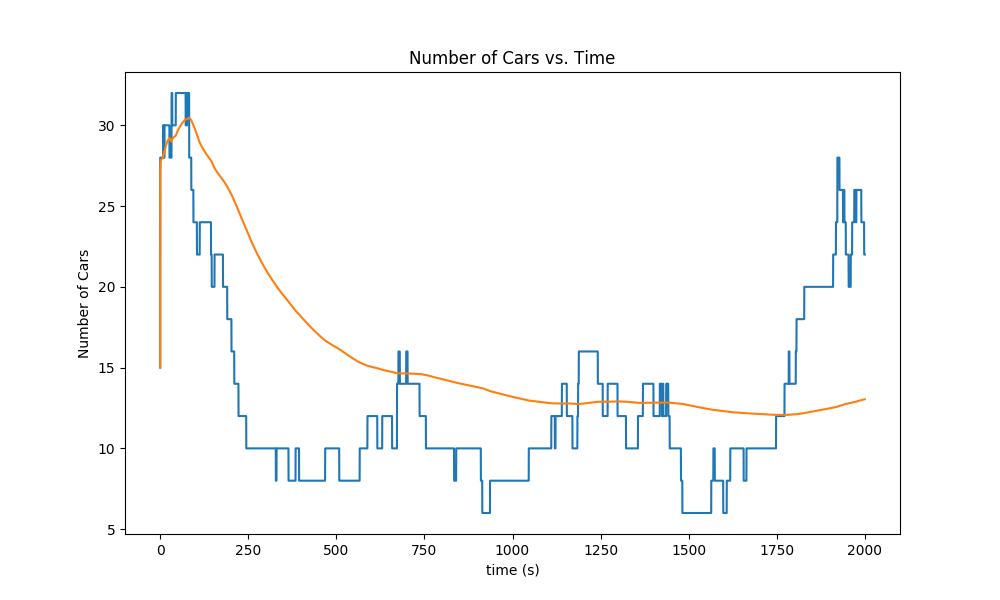

In [30]:
#EVL = params['s0']+params['lc']   # effective vehicle length
#max_occupancy = params['lr']/EVL  # maximum number of cars on the road

# calculate the average number of cars over time
avg_cars = np.zeros(n_cars_cur.shape[0])
for i in range(avg_cars.shape[0]):
    avg_cars[i] = np.average(n_cars_cur[0:i])
    
print(avg_cars[-1])  


plt.figure(figsize=(10,6))

plt.plot(t,n_cars_cur)
plt.plot(t,avg_cars)

# max occupancy is over 160, I recommend not putting
#plt.plot(t,max_occupancy*np.ones(len(t)))

plt.title("Number of Cars vs. Time")
plt.xlabel('time (s)')

plt.ylabel('Number of Cars')
plt.show()